Astropy: Affiliated Packages
=========================

Python packages developed independently of astropy, but following astropy standards.<br/>
https://www.astropy.org/affiliated/

Astroquery
----------------

https://astroquery.readthedocs.io

Accesing astronomical DB and archives through python.

- SDSS
- IRSA (WISE, 2MASS, IRAS, etc)
- MAST (HST, Galex, etc)
- UKIDSS and VSA (Vista surveys)
- Vizier and SIMBAD
- many, many more

In [1]:
from astroquery.simbad import Simbad

result_table = Simbad.query_object("m1")
result_table.show_in_notebook()

idx,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
0,M 1,05 34 31.94,+22 00 52.2,6,6,--,--,0,C,R,2011A&A...533A..10L


In [7]:
from astropy import coordinates
import astropy.units as u

# works only for ICRS coordinates:
c = coordinates.SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')
r = 1 * u.arcminute
result_table = Simbad.query_region(c, radius=r)
result_table.show_in_notebook()

NameError: name 'Simbad' is not defined

In [6]:
from astroquery.vizier import Vizier

v = Vizier(keywords=['stars:white_dwarf'])

c = coordinates.SkyCoord(0, 0, unit=('deg', 'deg'), frame='icrs')
result = v.query_region(c, radius=2*u.deg)

print(len(result))
result[0].show_in_notebook()

NameError: name 'coordinates' is not defined

Get a whole catalogue from Vizier:

In [8]:
v = Vizier(columns=['Xseq', 'RAJ2000', 'DEJ2000'], row_limit=-1, column_filters={'DEJ2000':'>-8'})
result = v.get_catalogs('IX/52/3xlss') # XXL catalogue
result[0].show_in_notebook()

idx,Xseq,RAJ2000,DEJ2000
,,deg,deg
0,206152,30.00941,-5.15580
1,206158,30.05835,-5.18158
2,224220,30.08191,-6.79755
3,224237,30.09684,-6.85438
4,224238,30.10105,-6.84212
5,224228,30.10387,-6.81029
6,224204,30.10397,-6.71023
7,224239,30.10840,-6.85276
8,222000,30.10856,-6.43635


In [1]:
from astroquery.mast import Mast, Observations

result = Observations.query_object('M83')
result.show_in_notebook()

idx,intentType,obs_collection,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,proposal_id,proposal_pi,dataproduct_type,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,distance
0,science,WUPPE,ASTRO-2 WUPPE,--,--,UV,NGC5236,--,ngc5236_624812_2,204.2549632722,-29.8645284872,--,--,spectrum,1,49782.78194444,49782.79453704,1088.0,152200000000.0,309800000000.0,--,--,--,--,CIRCLE ICRS 204.2549632722 -29.8645284872 0.00166666666667,http://archive.stsci.edu/pub/browse/previews/astro/wuppe/gif/ngc5236_624812_2_hwa.gif,http://archive.stsci.edu/pub/vospectra/wuppe2/ngc5236_624812_2_hw_vo.fits,PUBLIC,--,5885.0,7000000180,7000000180,0.0
1,science,WUPPE,ASTRO-2 WUPPE,--,--,UV,NGC5236,--,ngc5236_624814_2,204.2549632722,-29.8645284872,--,--,spectrum,1,49793.45694444,49793.46361111,576.0,152400000000.0,309400000000.0,--,--,--,--,CIRCLE ICRS 204.2549632722 -29.8645284872 0.00166666666667,http://archive.stsci.edu/pub/browse/previews/astro/wuppe/gif/ngc5236_624814_2_hwa.gif,http://archive.stsci.edu/pub/vospectra/wuppe2/ngc5236_624814_2_hw_vo.fits,PUBLIC,--,5885.0,7000000181,7000000181,0.0
2,science,SWIFT,UVOT,--,U,OPTICAL,CXOJ133705.14-295606.9,--,00031905002,204.283899124964,-29.8855211560682,--,--,cube,2,55564.706169,55564.7752778,394.927700170472,301400000000.0,394200000000.0,--,--,--,--,POLYGON -155.93325200000004 -29.892473 -155.82237199999997 -29.986037 -155.81268078769807 -29.993394812447868 -155.71326899999997 -30.081808 -155.70481369806214 -30.075168719847824 -155.70129299999996 -30.077834 -155.66205240924884 -30.04156971934481 -155.480679 -29.898651 -155.474902 -29.893063 -155.48793198074617 -29.880194721451289 -155.48100799999997 -29.873762 -155.583396 -29.789121 -155.59703867798319 -29.778849898686783 -155.68791 -29.697219 -155.69669830762535 -29.7037131690757 -155.711297 -29.692691 -155.822159 -29.788585 -155.88374784984541 -29.846217647746649 -155.92748900000004 -29.881116 -155.9243795385436 -29.884187322962138 -155.93325200000004 -29.892473 -155.93325200000004 -29.892473,http://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=sw00031905002uuu[1]&size=ALL&output_size=1407,http://archive.stsci.edu/missions/swift_uvot/00031905/00031905002/sw00031905002uuu_sk.img,PUBLIC,--,5885.0,15000717557,15000706212,0.0
3,science,SWIFT,UVOT,--,U,OPTICAL,CXOJ133705.14-295606.9,--,00031905003,204.262893527841,-29.8507046508678,--,--,cube,2,55565.5772917,55565.6562384,1618.487493708592,301400000000.0,394200000000.0,--,--,--,--,POLYGON -155.95138399999996 -29.841936 -155.85504500000002 -29.940226 -155.77824546683578 -30.010787021820786 -155.744215 -30.047927 -155.485272 -29.881754 -155.50182712564413 -29.861900410063374 -155.50120900000002 -29.861425 -155.50878519389437 -29.853553031990735 -155.568102 -29.782321 -155.674211 -29.667511 -155.691110896714 -29.677653631646024 -155.70964800000002 -29.660831 -155.95138399999996 -29.841936 -155.95138399999996 -29.841936,http://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=sw00031905003uuu[2]&size=ALL&output_size=1397,http://archive.stsci.edu/missions/swift_uvot/00031905/00031905003/sw00031905003uuu_sk.img,PUBLIC,--,5885.0,15000736255,15000727477,0.0
4,science,SWIFT,UVOT,--,U,OPTICAL,CXOJ133705.14-295606.9,--,00031905004,204.291913045924,-29.855663397303,--,--,cube,2,55568.4031134,55568.6104167,2154.559471352099,301400000000.0,394200000000.0,--,--,--,--,POLYGON -155.91949899999997 -29.837088 -155.88985124270144 -29.872184196885364 -155.896453 -29.877116 -155.79587300000003 -29.979296 -155.79487463611594 -29.98020744812279 -155.74896221714081 -30.029048039918059 -155.71437400000002 -30.067407 -155.70542512674294 -30.061771208699664 -155.685096 -30.080281 -155.4588876027403 -29.906016670699156 -155.454413 -29.903181 -155.45472317414448 -29.902799154207027 -155.445152 -29.895403 -155.50297013367575 -29.836697213351787 -155.51117299999999 -29.82685 -1

In [2]:
selected_bands = result[(result['obs_collection'] == 'HST') &
                        (result['instrument_name'] == 'WFC3/UVIS') &
                        ((result['filters'] == 'F657N') |
                         (result['filters'] == 'F487N') |
                         (result['filters'] == 'F336W')) &
                        (result['target_name'] == 'MESSIER-083')]
selected_bands.show_in_notebook()

idx,intentType,obs_collection,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,proposal_id,proposal_pi,dataproduct_type,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,distance
0,science,HST,WFC3/UVIS,HST,F336W,Optical,MESSIER-083,GALAXY;SPIRAL;STAR FORMING REGION;STARBURST,ib6w61060,204.2684583333,-29.85777777778,11360,"OConnell, Robert W.",image,3,55069.30420139,55069.43802083,1890.0,305.8,367.3,Star Formation in Nearby Galaxies,55083.66667,GO/DD,--,POLYGON -155.75312226 -29.88525801 -155.75265559182071 -29.885210175751723 -155.75250071 -29.88598688 -155.75203402137865 -29.885939044017569 -155.75187914000003 -29.88671574 -155.69978674000004 -29.88136584 -155.70933041 -29.83678117 -155.70978727853711 -29.836823534602779 -155.70995229 -29.83605231 -155.71040913811734 -29.836094673019222 -155.71057415 -29.83532344 -155.76212434 -29.84009353 -155.75312226 -29.88525801 -155.75312226 -29.88525801,mast:HST/product/ib6w61060_drz.jpg,mast:HST/product/ib6w61060_drz.fits,PUBLIC,False,--,2003841056,2027443198,0.0
1,science,HST,WFC3/UVIS,HST,F657N,Optical,MESSIER-083,GALAXY;SPIRAL;STAR FORMING REGION;STARBURST,ib6w62010,204.2684583333,-29.85777777778,11360,"OConnell, Robert W.",image,3,55068.72520833,55068.82686343,1484.0,649.3,664.9,Star Formation in Nearby Galaxies,55083.66667,GO/DD,--,POLYGON -155.752247 -29.885727 -155.75222267880244 -29.885724550471668 -155.75221799999997 -29.885747 -155.75178310154976 -29.885703199867912 -155.751626 -29.886457 -155.6997 -29.881216 -155.69970510934755 -29.881191539433882 -155.69968 -29.881189 -155.704343 -29.858866 -155.70480171361851 -29.858912384197676 -155.704954 -29.858183 -155.70498047406934 -29.858185676384633 -155.70498499999997 -29.858164 -155.75689799999998 -29.863402 -155.752247 -29.885727 -155.752247 -29.885727,mast:HST/product/ib6w62010_drz.jpg,mast:HST/product/ib6w62010_drz.fits,PUBLIC,False,--,2003841060,2027497500,0.0
2,science,HST,WFC3/UVIS,HST,F487N,Optical,MESSIER-083,GALAXY;SPIRAL;STAR FORMING REGION;STARBURST,ib6w62020,204.2684583333,-29.85777777778,11360,"OConnell, Robert W.",image,3,55068.82686343,55068.96041667,2700.0,483.6,490.8,Star Formation in Nearby Galaxies,55083.66667,GO/DD,--,POLYGON -155.75312226 -29.88525801 -155.75265559182071 -29.885210175751709 -155.75250071 -29.88598688 -155.75203402137868 -29.885939044017569 -155.75187914000003 -29.88671574 -155.69978674000004 -29.88136584 -155.70933041 -29.83678117 -155.70978727853711 -29.836823534602736 -155.70995229 -29.83605231 -155.71040913811737 -29.836094673019225 -155.71057415 -29.83532344 -155.76212434 -29.84009353 -155.75312226 -29.88525801 -155.75312226 -29.88525801,mast:HST/product/ib6w62020_drz.jpg,mast:HST/product/ib6w62020_drz.fits,PUBLIC,False,--,2003841061,2027496448,0.0


In [3]:
prodlist = Observations.get_product_list(selected_bands)
filtered_prodlist = Observations.filter_products(prodlist, productSubGroupDescription='DRC')
filtered_prodlist.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
0,2003841056,HST,image,ib6w61060,DADS DRC file - CTE-corrected calibrated combined image ACS/WFC3,C,mast:HST/product/ib6w61060_drc.fits,SCIENCE,Minimum Recommended Products,DRC,--,CALWF3,3.5.0(Oct-09-2018),11360,ib6w61060_drc.fits,228507840,2003841056
1,2003841060,HST,image,ib6w62010,DADS DRC file - CTE-corrected calibrated combined image ACS/WFC3,C,mast:HST/product/ib6w62010_drc.fits,SCIENCE,Minimum Recommended Products,DRC,--,CALWF3,3.5.0(Oct-09-2018),11360,ib6w62010_drc.fits,222914880,2003841060
2,2003841061,HST,image,ib6w62020,DADS DRC file - CTE-corrected calibrated combined image ACS/WFC3,C,mast:HST/product/ib6w62020_drc.fits,SCIENCE,Minimum Recommended Products,DRC,--,CALWF3,3.5.0(Oct-09-2018),11360,ib6w62020_drc.fits,228568320,2003841061


In [4]:
downloaded = Observations.download_products(filtered_prodlist)
downloaded

Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/ib6w61060/ib6w61060_drc.fits,COMPLETE,None,None
./mastDownload/HST/ib6w62010/ib6w62010_drc.fits,COMPLETE,None,None
./mastDownload/HST/ib6w62020/ib6w62020_drc.fits,COMPLETE,None,None


In [9]:
from astropy.io import fits
import reproject   # Other Astropy affiliated package

blue = fits.open(downloaded['Local Path'][0])
red = fits.open(downloaded['Local Path'][1])
green = fits.open(downloaded['Local Path'][2])

target_header = red['SCI'].header
green_repr, _ = reproject.reproject_interp(green['SCI'], target_header)
blue_repr, _ = reproject.reproject_interp(blue['SCI'], target_header)

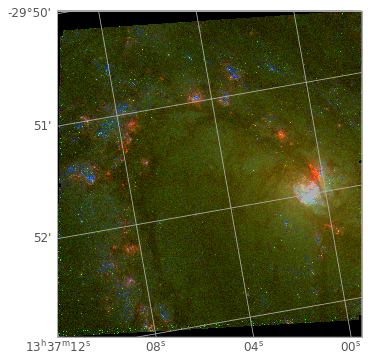

In [12]:
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb, ImageNormalize, astropy_mpl_style
import matplotlib.pyplot as plt

rgb_img = make_lupton_rgb(ImageNormalize(vmin=0, vmax=1)(red['SCI'].data),
                          ImageNormalize(vmin=0, vmax=0.3)(green_repr),
                          ImageNormalize(vmin=0, vmax=1)(blue_repr),
                          stretch=0.1, minimum=0)

plt.style.use(astropy_mpl_style)

plt.subplot(111, projection=WCS(target_header))
plt.imshow(rgb_img, origin='lower', interpolation='none')
plt.show()

Regions
------------
https://astropy-regions.readthedocs.io

Define geometrical regions in the sky

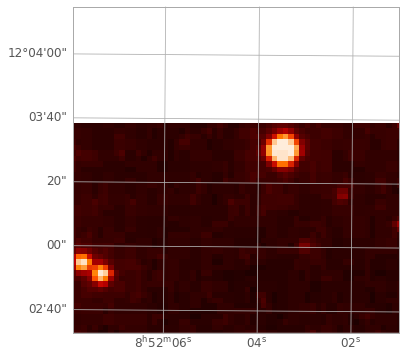

In [22]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('photometry/M6707HH.fits')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

plt.subplot(111, projection=wcs)
plt.imshow(hdu.data, origin='lower', interpolation='none')
plt.xlim(120, 180)
plt.ylim(1020, 1080)
plt.show()

In [21]:
from regions import PixCoord

box_pixcoords = PixCoord(x=[120, 120, 180, 180], y=[1020, 1080, 1020, 1080])
box_skycoords = box_pixcoords.to_sky(wcs=wcs)
box_skycoords.to_string('hmsdms')


['08h52m07.9215s +12d02m32.7504s',
 '08h52m07.9714s +12d04m14.7854s',
 '08h52m00.9675s +12d02m33.483s',
 '08h52m01.0167s +12d04m15.5177s']

In [50]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

center_sky = SkyCoord(133.01452905, 12.05838643, unit='deg', frame='icrs')
circle_sky = CircleSkyRegion(center=center_sky, radius=6*u.arcsec)
print(circle_sky)

aperture = circle_sky.to_pixel(wcs)
print(aperture)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (133.01452905, 12.05838643)>
radius: 6.0 arcsec
Region: CirclePixelRegion
center: PixCoord(x=158.48759850055248, y=1053.4878805875471)
radius: 3.5281165791730764


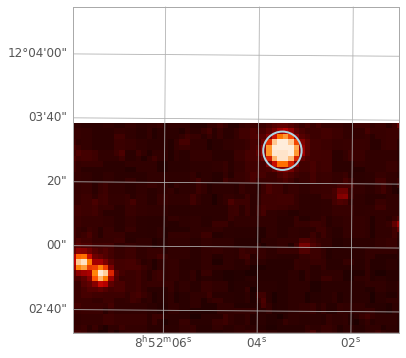

In [51]:
ax = plt.subplot(111, projection=wcs)
ax.imshow(hdu.data, origin='lower', interpolation='none')
ax.add_artist(aperture.as_artist(facecolor='none', edgecolor='lightblue', lw=2))

ax.set_xlim(120, 180)
ax.set_ylim(1020, 1080)
plt.show()

In [53]:
mask = aperture.to_mask(mode='exact') # center
data = mask.cutout(hdu.data)
weighted_data = mask.multiply(hdu.data)
mask.data

array([[0.        , 0.        , 0.19932553, 0.49418177, 0.49059312,
        0.18951489, 0.        , 0.        ],
       [0.        , 0.48359386, 0.99599523, 1.        , 1.        ,
        0.99397585, 0.46081025, 0.        ],
       [0.19946358, 0.99600608, 1.        , 1.        , 1.        ,
        1.        , 0.99275298, 0.17791368],
       [0.49442407, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.46962107],
       [0.49091704, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.46611404],
       [0.18986925, 0.99403948, 1.        , 1.        , 1.        ,
        1.        , 0.99018519, 0.16892055],
       [0.        , 0.46132164, 0.99282303, 1.        , 1.        ,
        0.99020245, 0.43913922, 0.        ],
       [0.        , 0.        , 0.17825891, 0.46994295, 0.46635429,
        0.16904947, 0.        , 0.        ]])

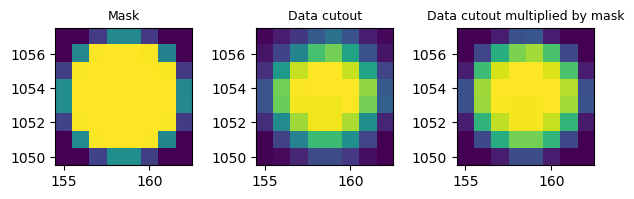

In [58]:
plt.style.use('default')

plt.subplot(1,3,1)
plt.title("Mask", size=9)
plt.imshow(mask.data, cmap=plt.cm.viridis,
           interpolation='nearest', origin='lower',
           extent=mask.bbox.extent)

plt.subplot(1,3,2)
plt.title("Data cutout", size=9)
plt.imshow(data, cmap=plt.cm.viridis,
           interpolation='nearest', origin='lower',
           extent=mask.bbox.extent)

plt.subplot(1,3,3)
plt.title("Data cutout multiplied by mask", size=9)
plt.imshow(weighted_data, cmap=plt.cm.viridis,
           interpolation='nearest', origin='lower',
           extent=mask.bbox.extent)

plt.tight_layout()
plt.show()

Using DS9 regions:

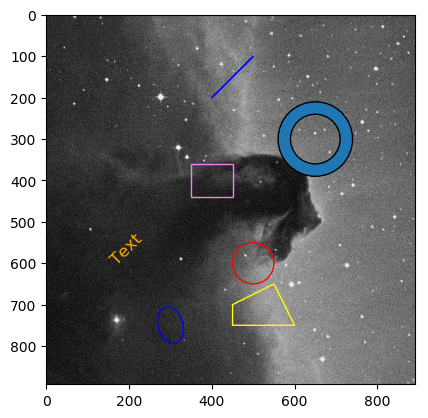

In [59]:
from astropy.utils.data import get_pkg_data_filename
from regions import read_ds9

image_file = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')
image_data = fits.getdata(image_file, ext=0)

ax = plt.gca()
plt.imshow(image_data, cmap='gray')

regs = read_ds9('plot_image.reg')
for i, reg in enumerate(regs):
    reg.plot(ax=ax)

plt.show()